# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

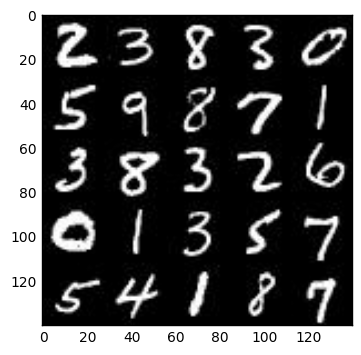

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

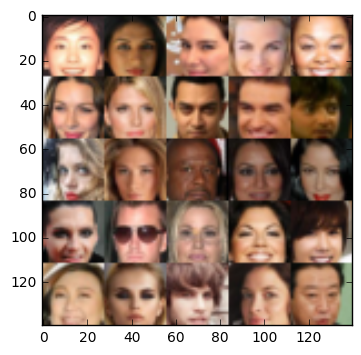

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Conv 4
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
       
        # Flatten
        flat = tf.reshape(lrelu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 3, 1, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, 2, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6984... Generator Loss: 0.0510


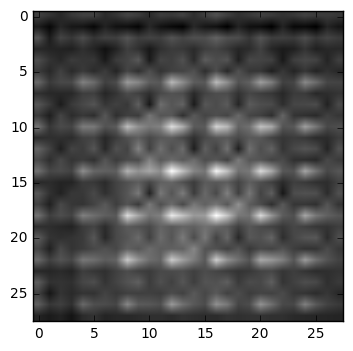

Epoch 1/2... Discriminator Loss: 1.9886... Generator Loss: 3.4377


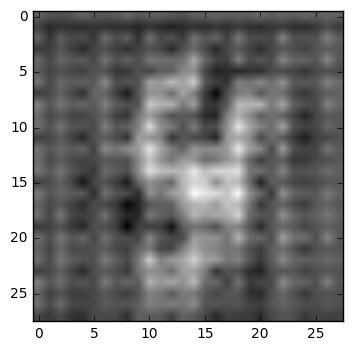

Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.5769


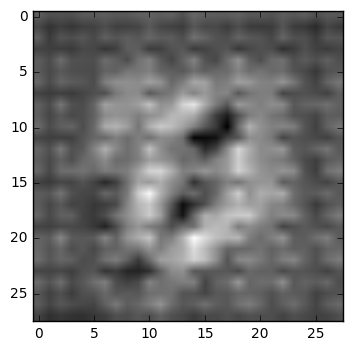

Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.7838


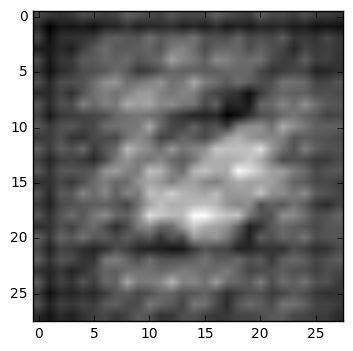

Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 2.0244


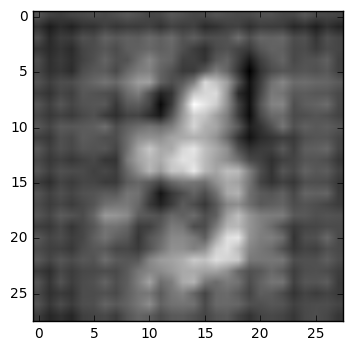

Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.8995


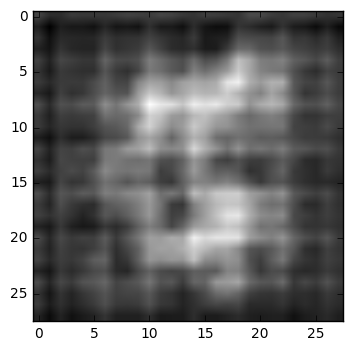

Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.3652


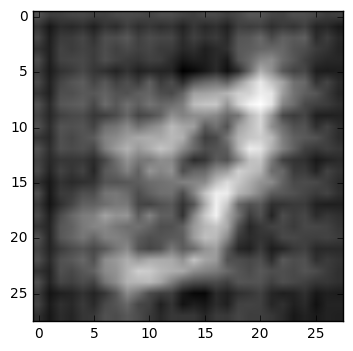

Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 0.9135


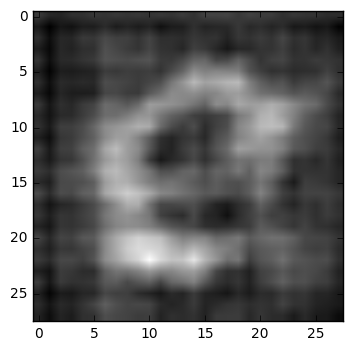

Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.2713


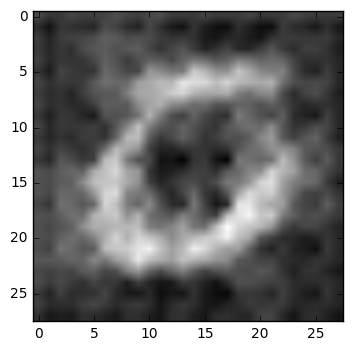

Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 2.8229


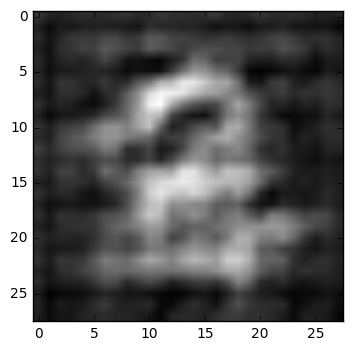

Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.5726


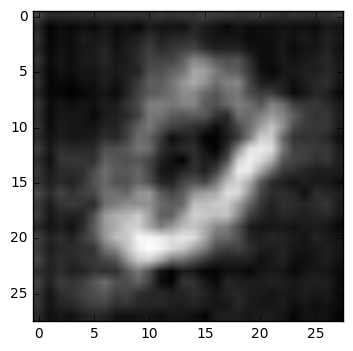

Epoch 1/2... Discriminator Loss: 1.7283... Generator Loss: 0.3345


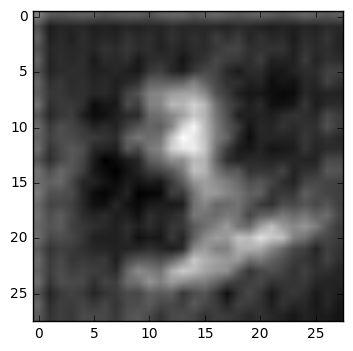

Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.7188


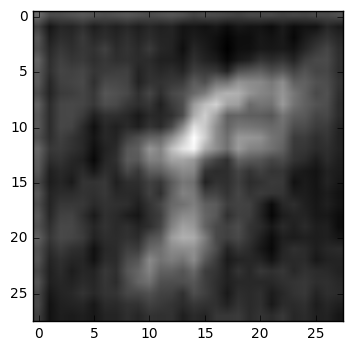

Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.5485


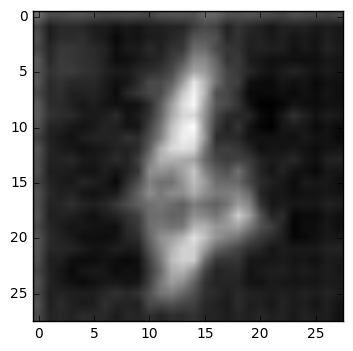

Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 1.1777


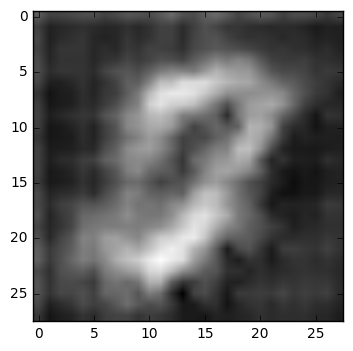

Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.4853


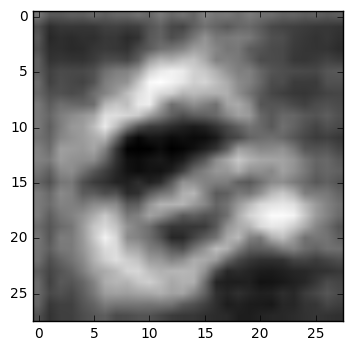

Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.6553


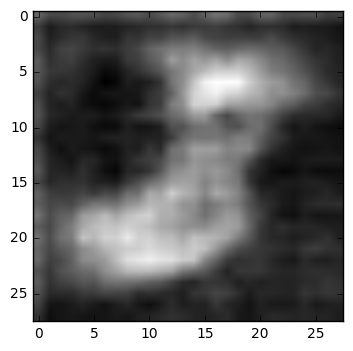

Epoch 1/2... Discriminator Loss: 2.2840... Generator Loss: 0.2908


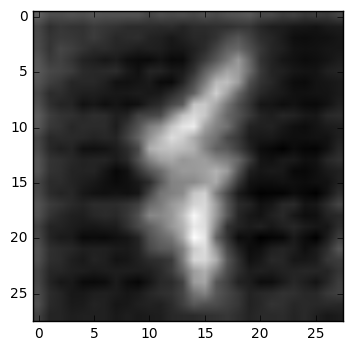

Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.4349


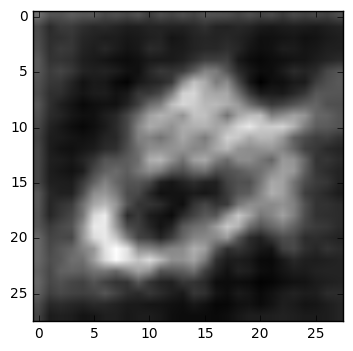

Epoch 1/2... Discriminator Loss: 2.1788... Generator Loss: 0.2584


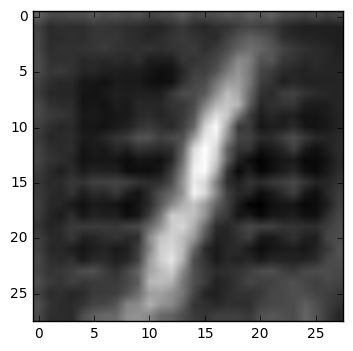

Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.1832


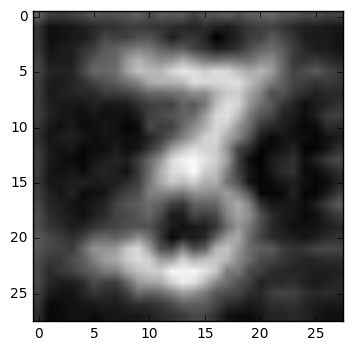

Epoch 1/2... Discriminator Loss: 3.3659... Generator Loss: 0.0863


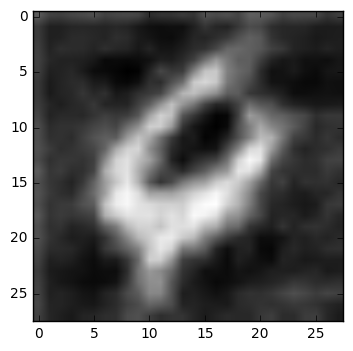

Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.1652


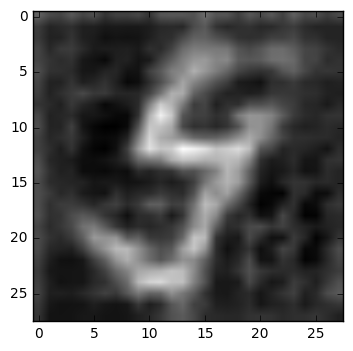

Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 1.2442


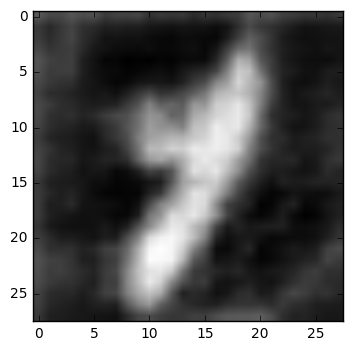

Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.2786


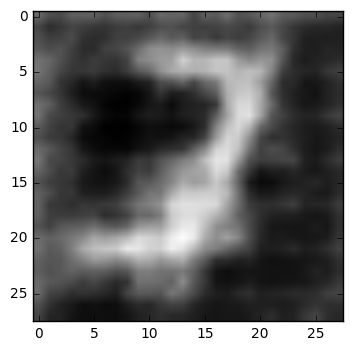

Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.6665


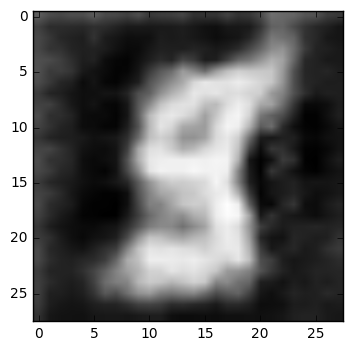

Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.8475


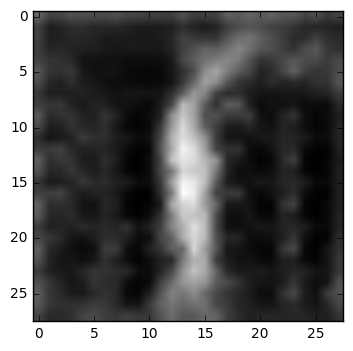

Epoch 1/2... Discriminator Loss: 1.6721... Generator Loss: 0.3522


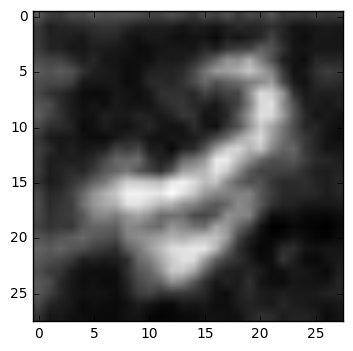

Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.8234


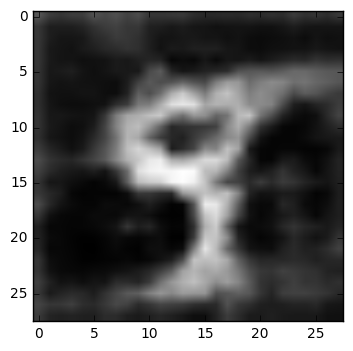

Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.4064


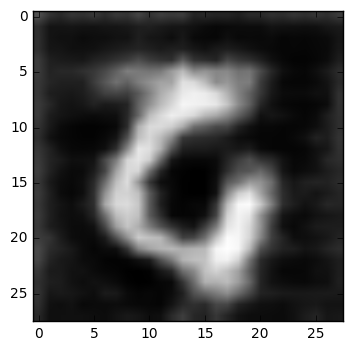

Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 2.2076


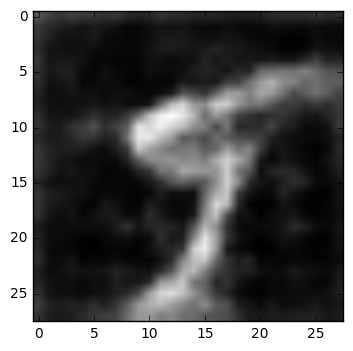

Epoch 1/2... Discriminator Loss: 2.1366... Generator Loss: 0.3832


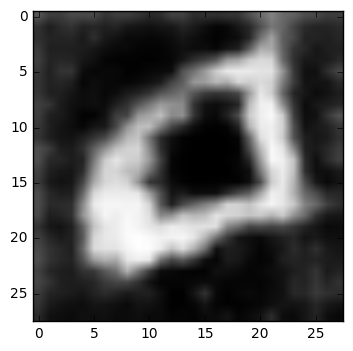

Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 1.9934


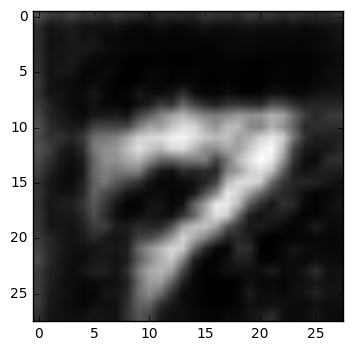

Epoch 1/2... Discriminator Loss: 2.4871... Generator Loss: 0.2360


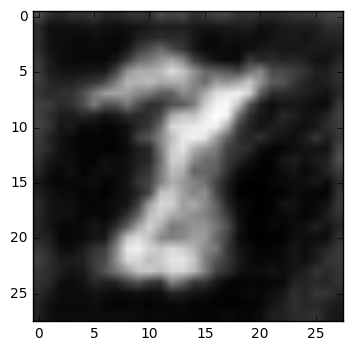

Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 2.0264


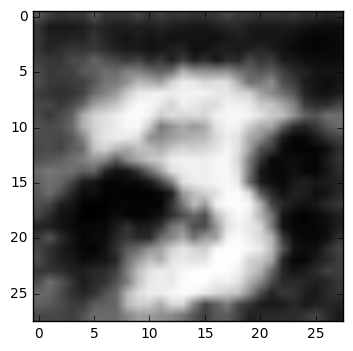

Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.6550


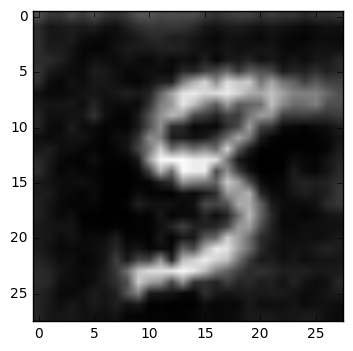

Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 0.8828


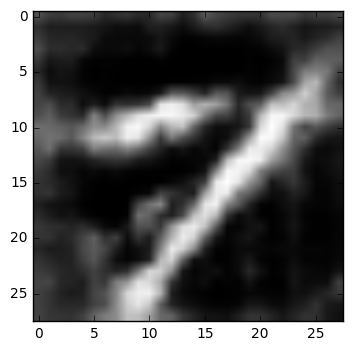

Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 0.8351


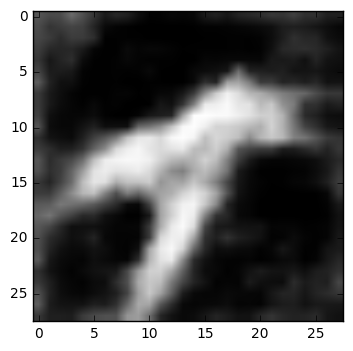

Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.4327


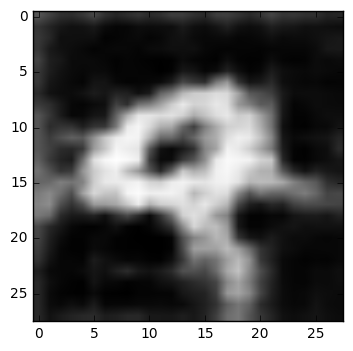

Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.7504


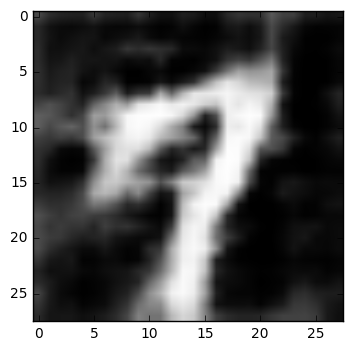

Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.0835


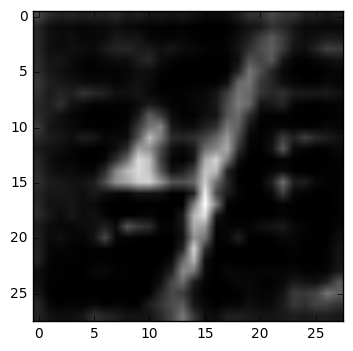

Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.4291


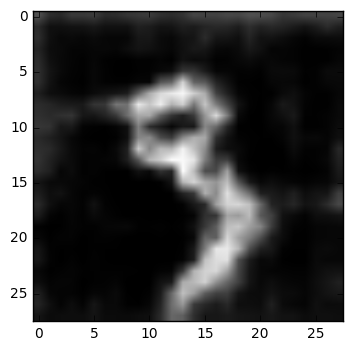

Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.3726


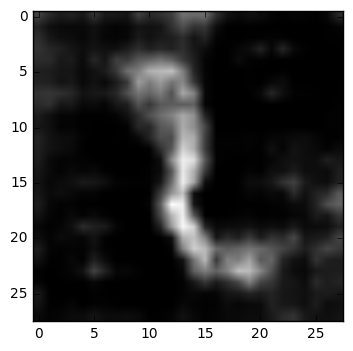

Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.7894


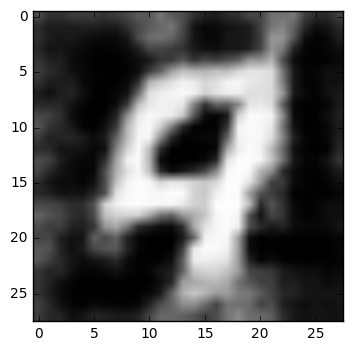

Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 1.4004


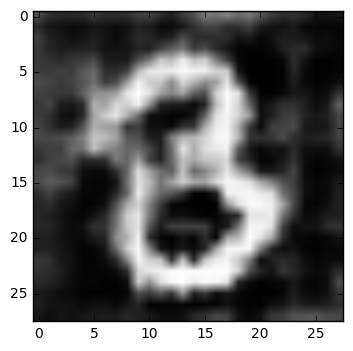

Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.7087


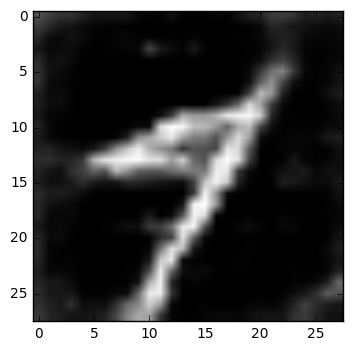

Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.3985


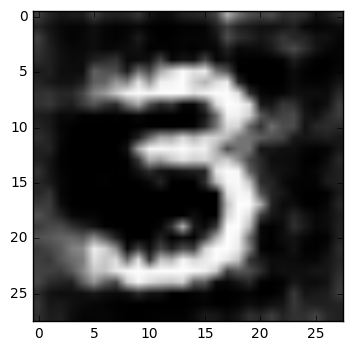

Epoch 1/2... Discriminator Loss: 2.0716... Generator Loss: 0.2869


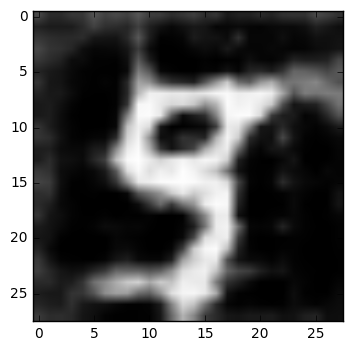

Epoch 1/2... Discriminator Loss: 2.2008... Generator Loss: 0.1957


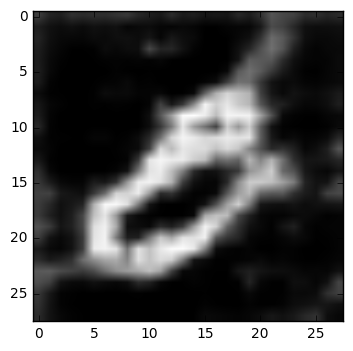

Epoch 1/2... Discriminator Loss: 2.1857... Generator Loss: 0.2759


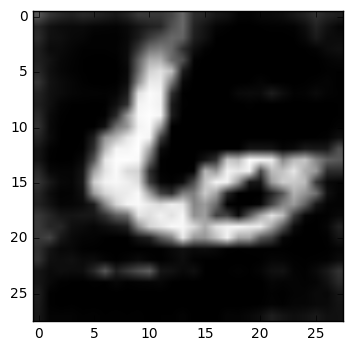

Epoch 1/2... Discriminator Loss: 1.9611... Generator Loss: 0.3261


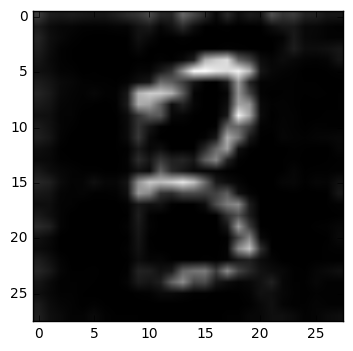

Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 2.6186


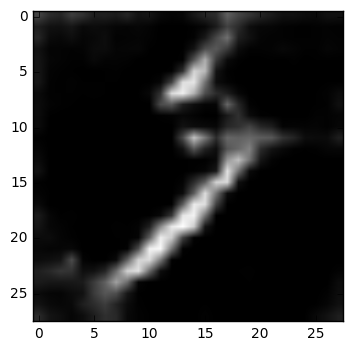

Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 1.1202


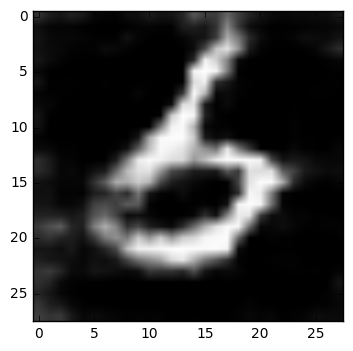

Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.4640


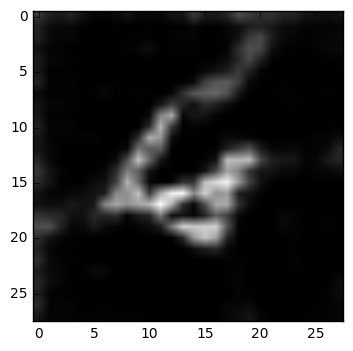

Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.9617


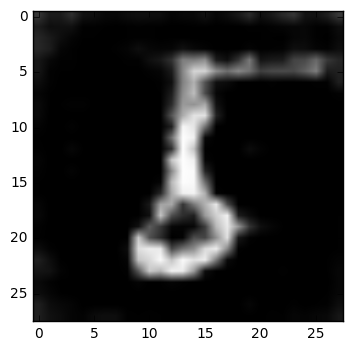

Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.3107


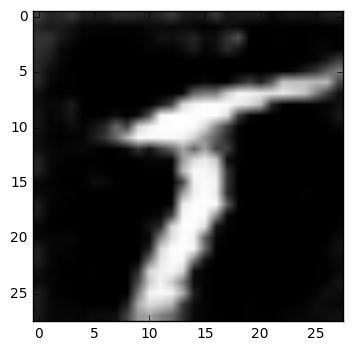

Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.3344


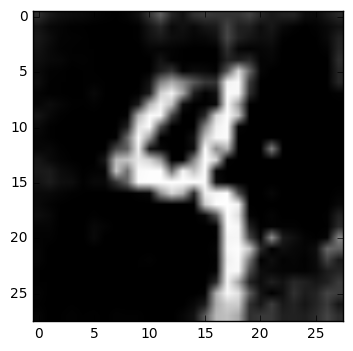

Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 3.4276


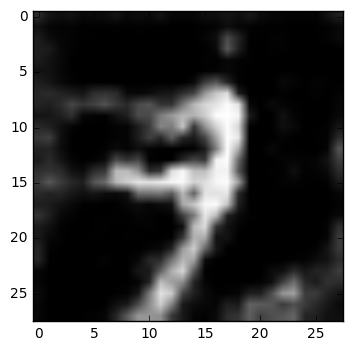

Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 2.2359


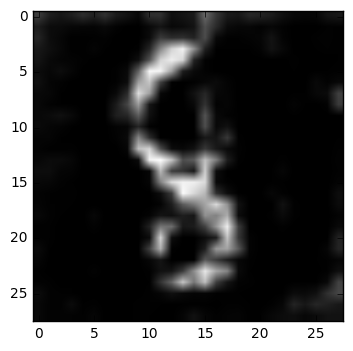

Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.1870


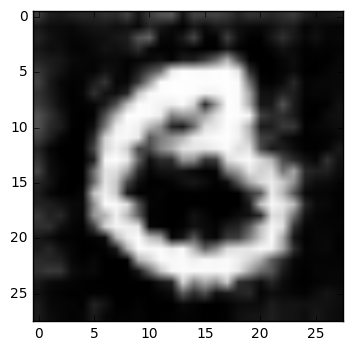

Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.7478


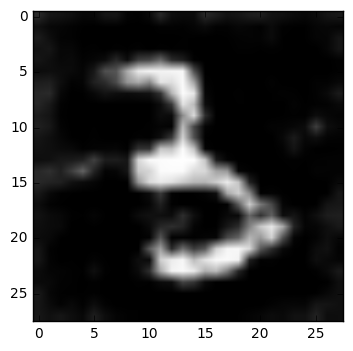

Epoch 2/2... Discriminator Loss: 2.3620... Generator Loss: 0.2366


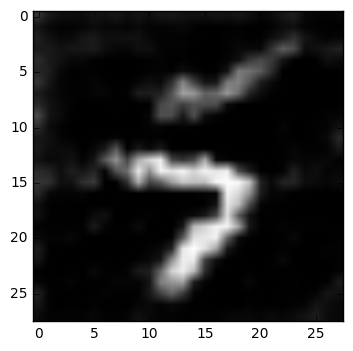

Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.6631


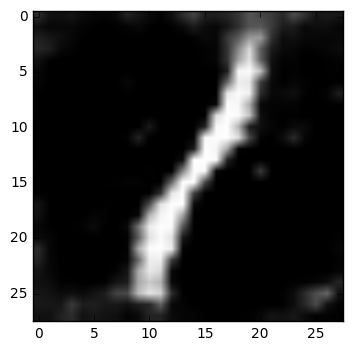

Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.8914


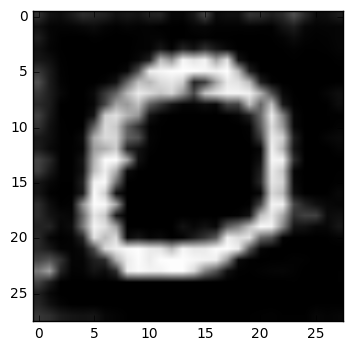

Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 2.7857


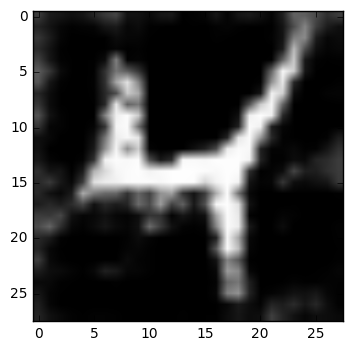

Epoch 2/2... Discriminator Loss: 1.8905... Generator Loss: 0.3608


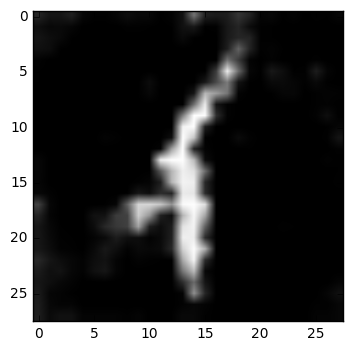

Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.1860


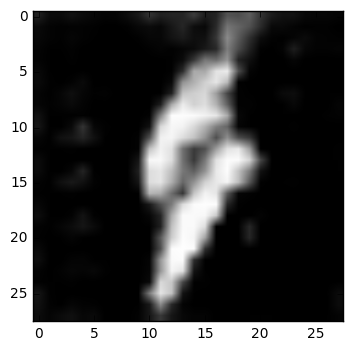

Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.8059


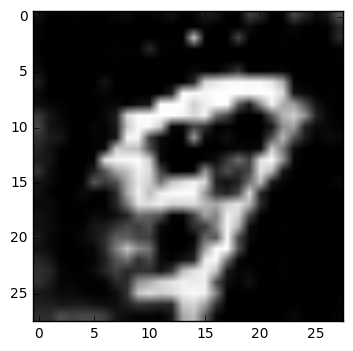

Epoch 2/2... Discriminator Loss: 0.5168... Generator Loss: 3.1270


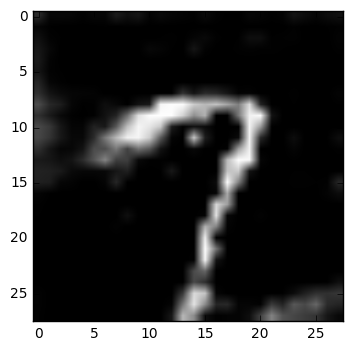

Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.7758


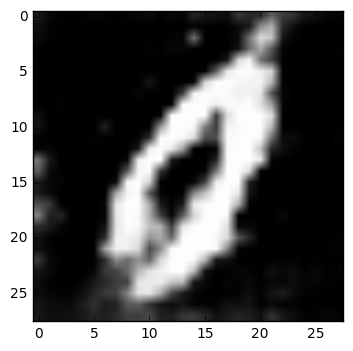

Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.2866


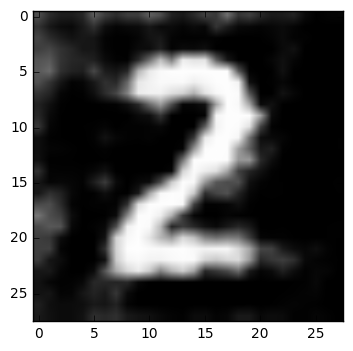

Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.6414


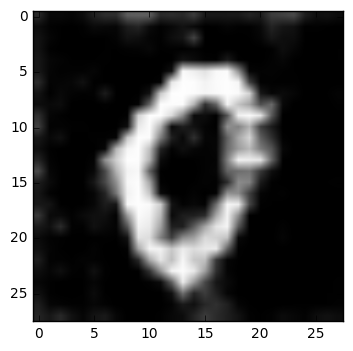

Epoch 2/2... Discriminator Loss: 0.5007... Generator Loss: 2.9569


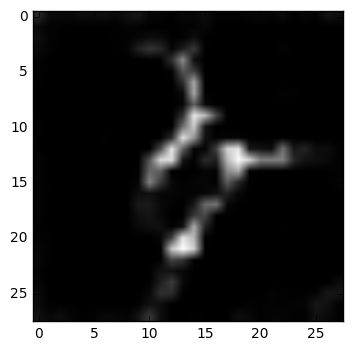

Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.5140


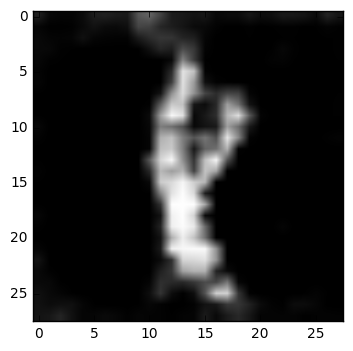

Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 1.0012


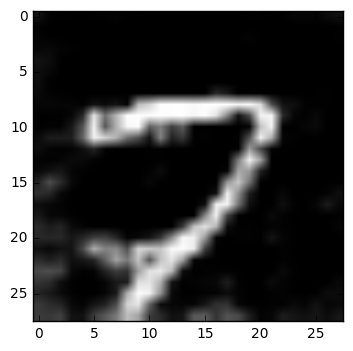

Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.9301


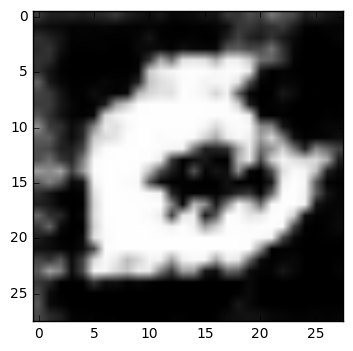

Epoch 2/2... Discriminator Loss: 2.0887... Generator Loss: 0.3380


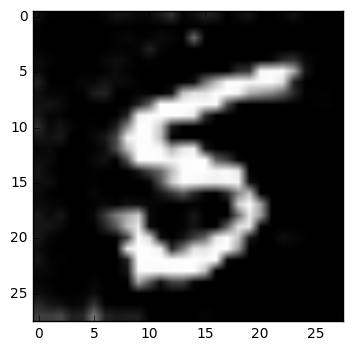

Epoch 2/2... Discriminator Loss: 2.3595... Generator Loss: 0.2402


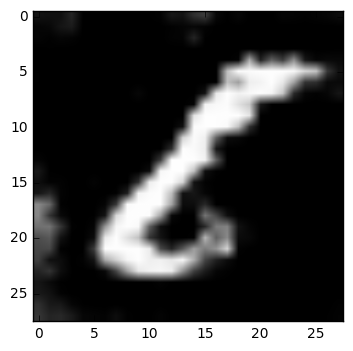

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 2.4769


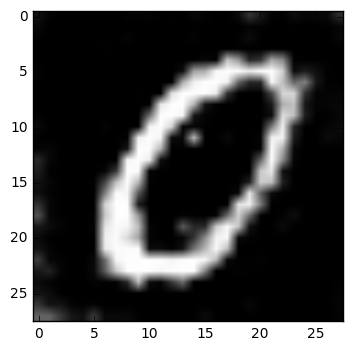

Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 1.6683


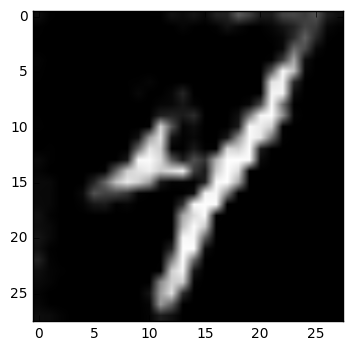

Epoch 2/2... Discriminator Loss: 2.1879... Generator Loss: 7.3466


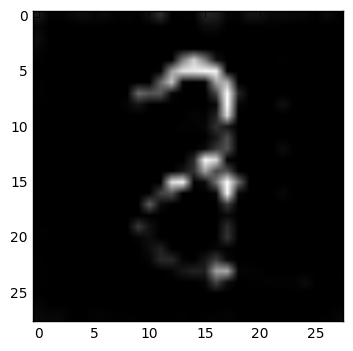

Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.8645


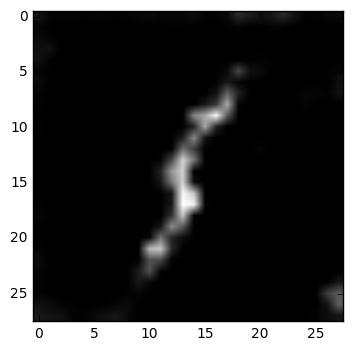

Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.7569


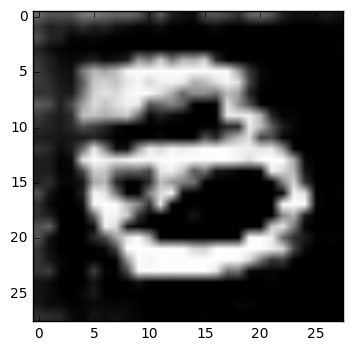

Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.3229


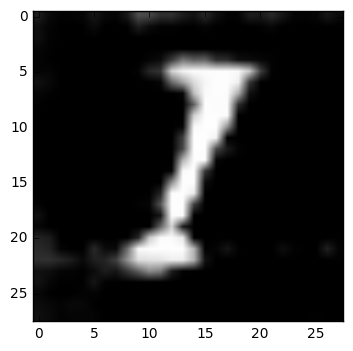

Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.4853


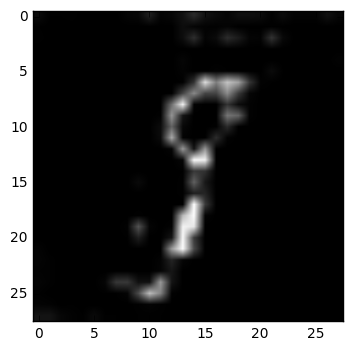

Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 1.4328


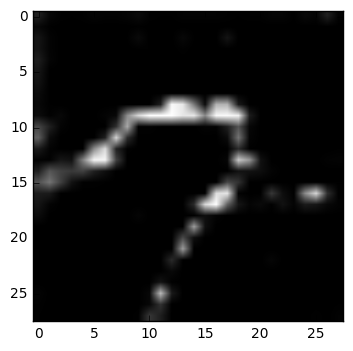

Epoch 2/2... Discriminator Loss: 2.3098... Generator Loss: 0.2289


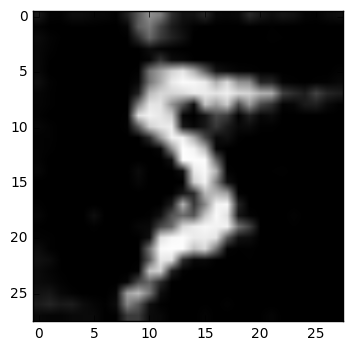

Epoch 2/2... Discriminator Loss: 1.7644... Generator Loss: 0.4902


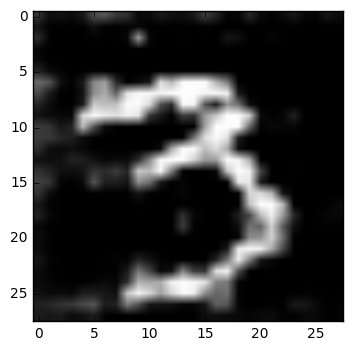

Epoch 2/2... Discriminator Loss: 2.1902... Generator Loss: 0.2957


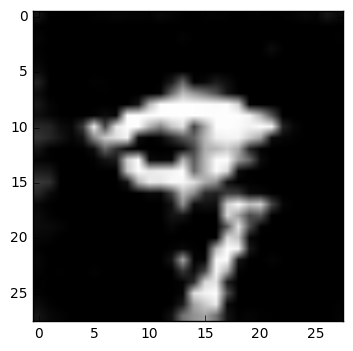

Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.6435


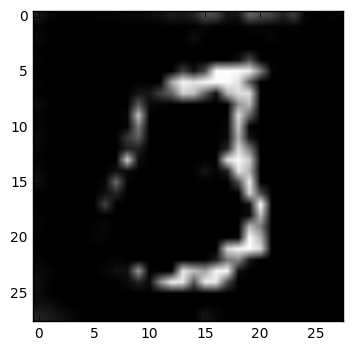

Epoch 2/2... Discriminator Loss: 1.8190... Generator Loss: 0.3927


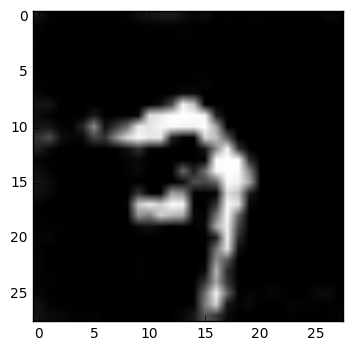

Epoch 2/2... Discriminator Loss: 2.6474... Generator Loss: 0.2168


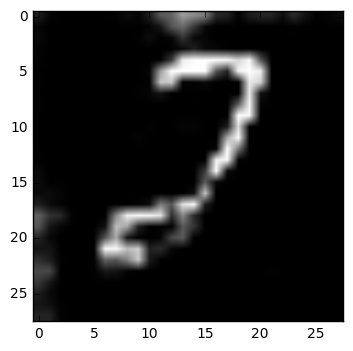

Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.5988


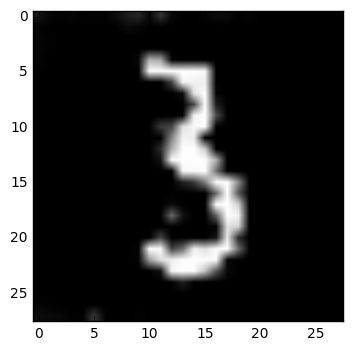

Epoch 2/2... Discriminator Loss: 1.9118... Generator Loss: 0.5141


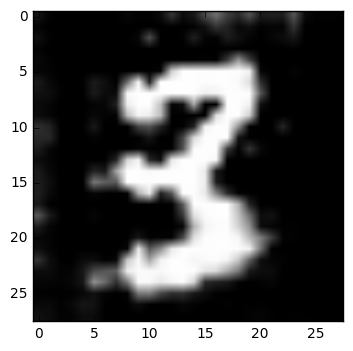

Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.5563


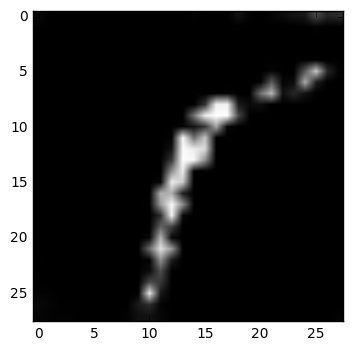

Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 3.2162


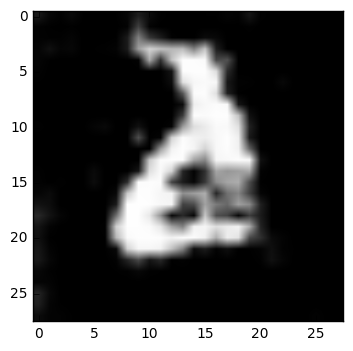

Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 2.4632


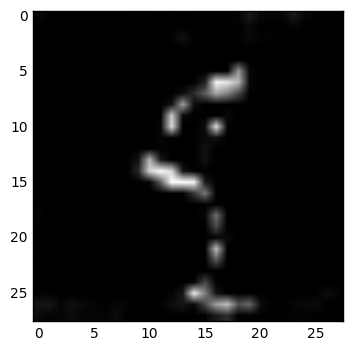

Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.5958


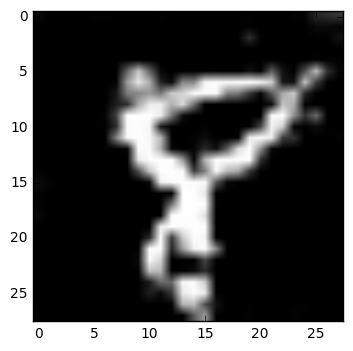

Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.6723


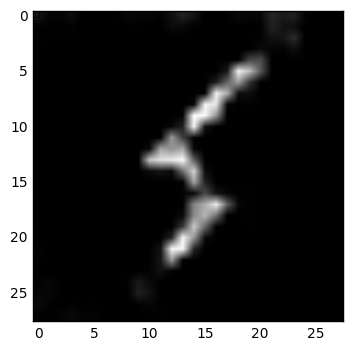

Epoch 2/2... Discriminator Loss: 1.9455... Generator Loss: 0.3146


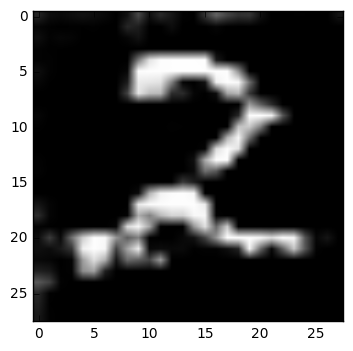

Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.2263


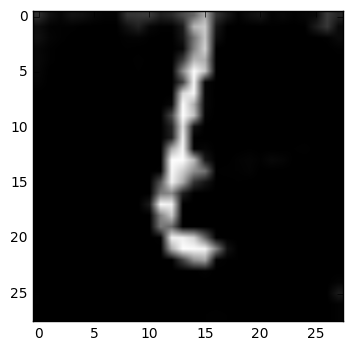

Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.9274


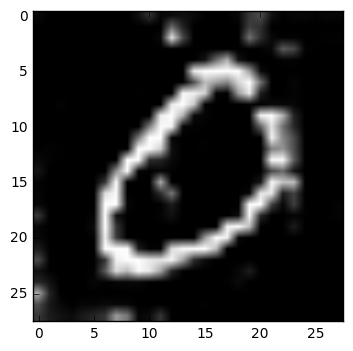

Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.0179


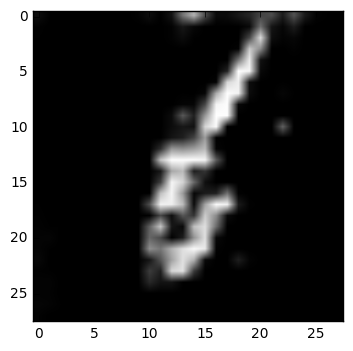

Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.3740


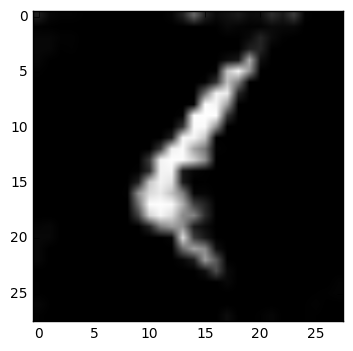

Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.6182


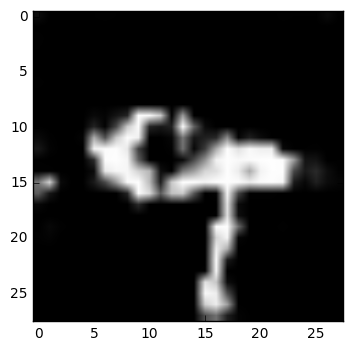

Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.8113


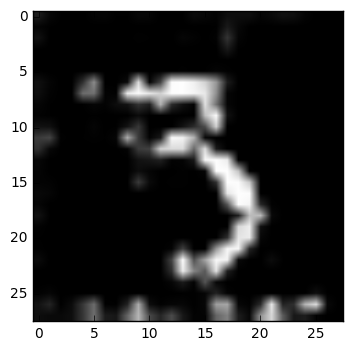

Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 2.4079


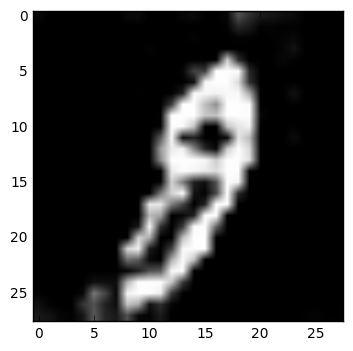

Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 2.4275


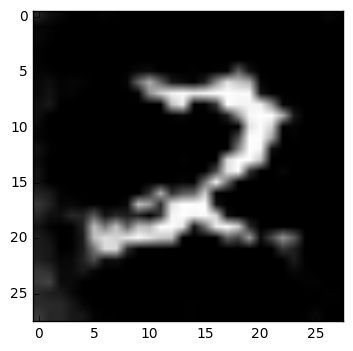

Epoch 2/2... Discriminator Loss: 1.9469... Generator Loss: 2.8815


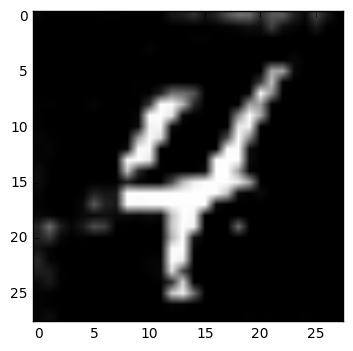

Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 2.3519


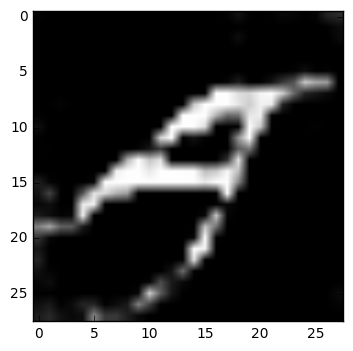

Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6333


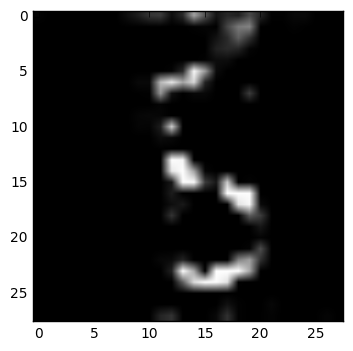

Epoch 2/2... Discriminator Loss: 2.2880... Generator Loss: 0.2181


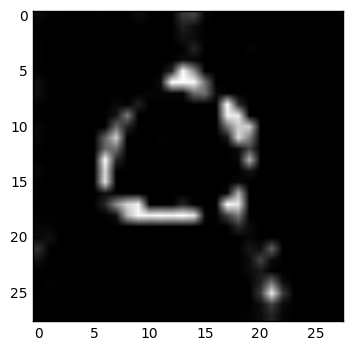

Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.4602


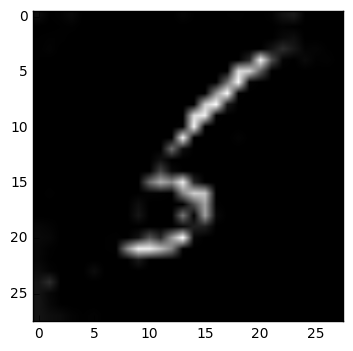

Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 2.7969


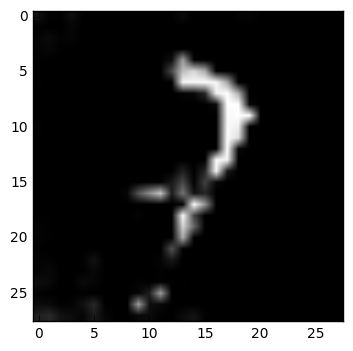

Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.8549


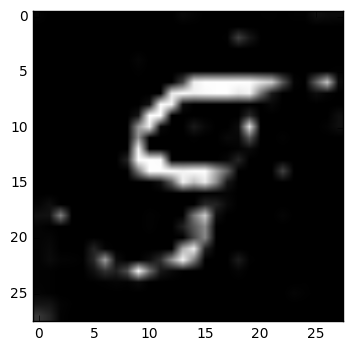

Epoch 2/2... Discriminator Loss: 1.9683... Generator Loss: 0.3906


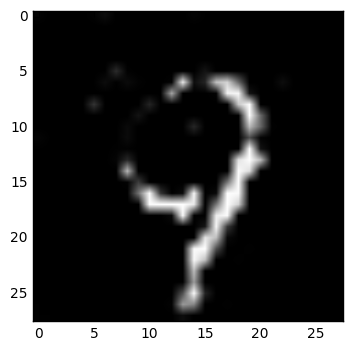

Epoch 2/2... Discriminator Loss: 2.2634... Generator Loss: 0.3091


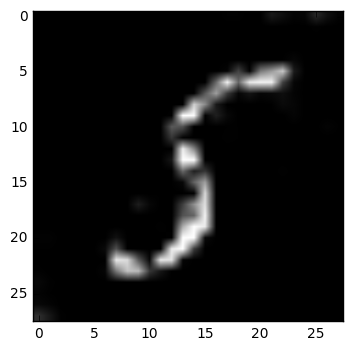

Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.7376


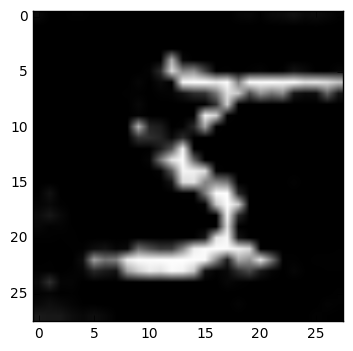

Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.9175


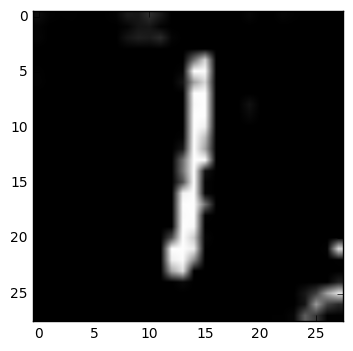

Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 2.2745


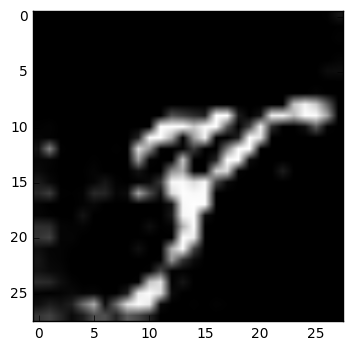

IndexError: list index out of range

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 2.1197


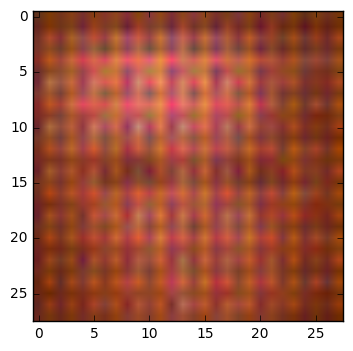

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8632


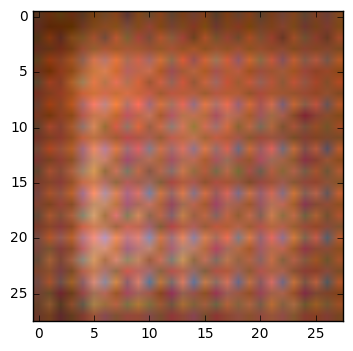

Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.5182


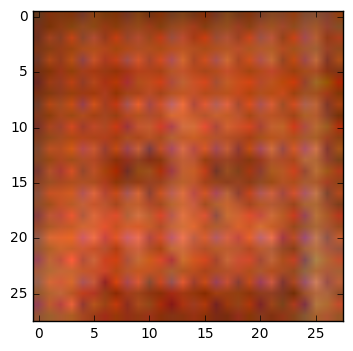

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.0215


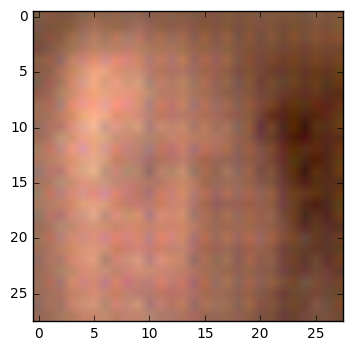

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5670


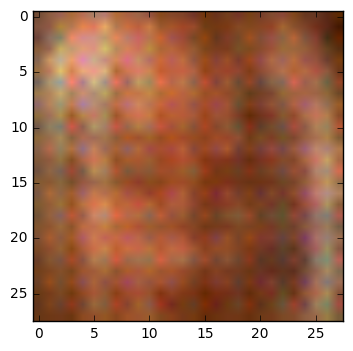

Epoch 1/1... Discriminator Loss: 1.9346... Generator Loss: 2.2103


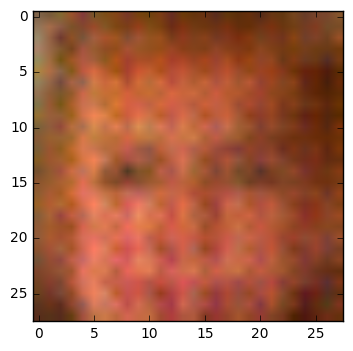

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0984


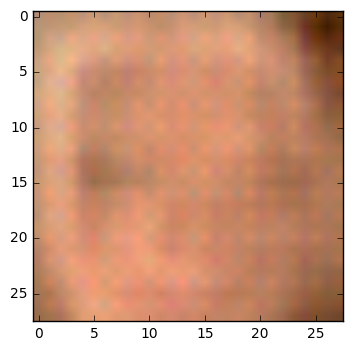

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5515


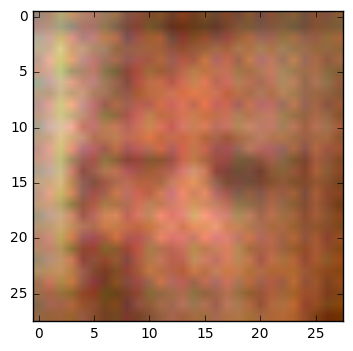

Epoch 1/1... Discriminator Loss: 1.9234... Generator Loss: 0.3773


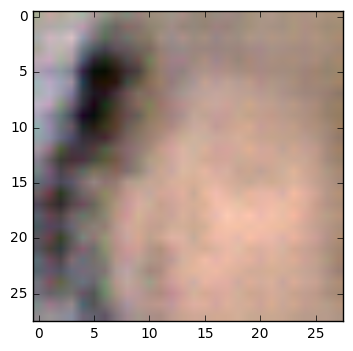

Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.1609


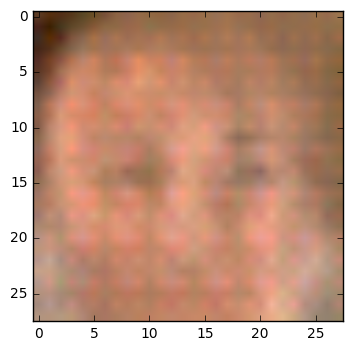

Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7084


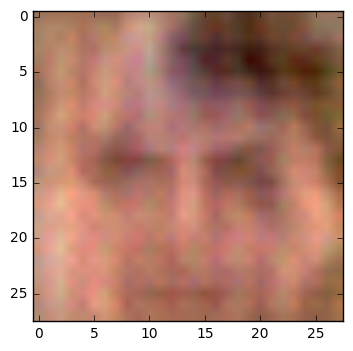

Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.1110


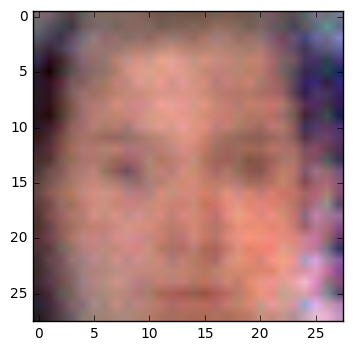

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6474


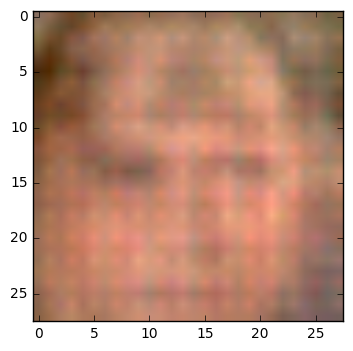

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 1.9515


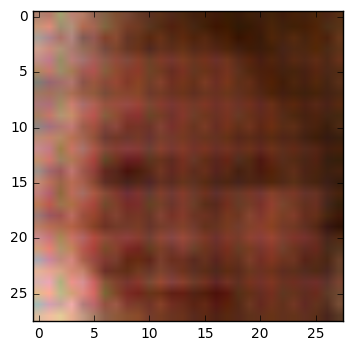

Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.3837


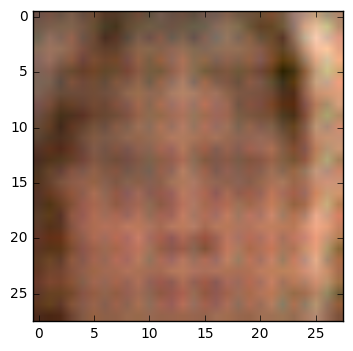

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7153


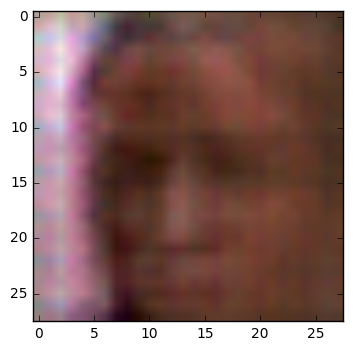

Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.1451


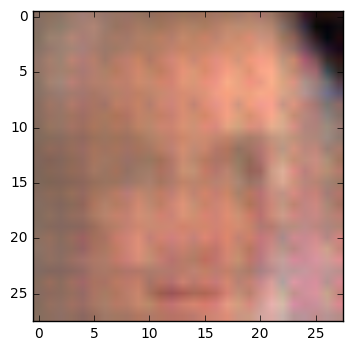

Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.0876


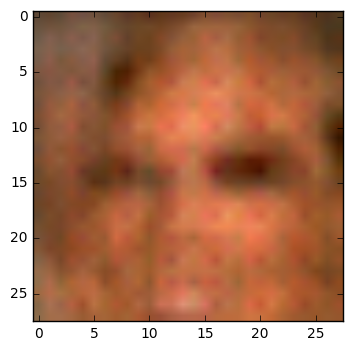

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9507


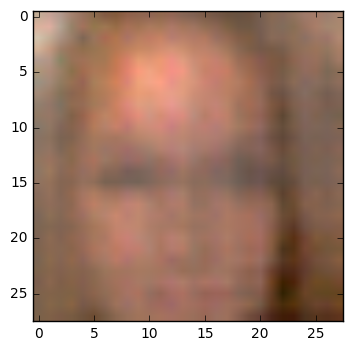

Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.7785


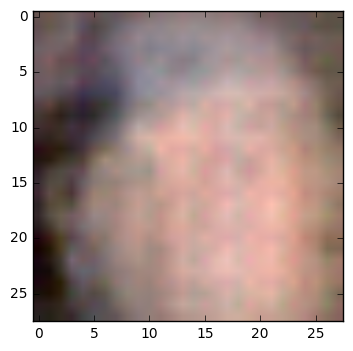

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6570


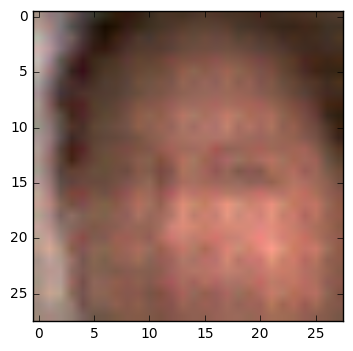

Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 1.2417


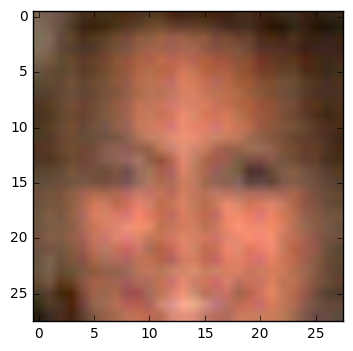

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.9658


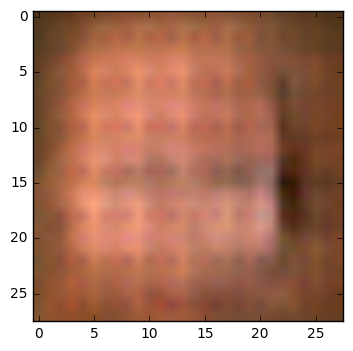

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.8698


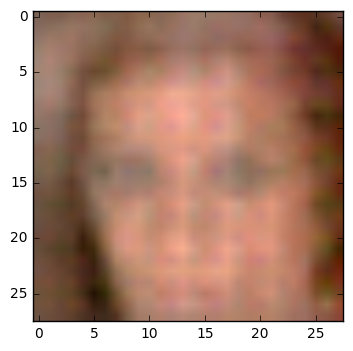

Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.0067


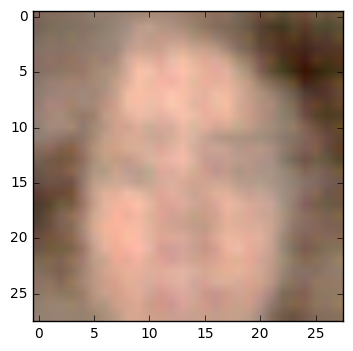

Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9756


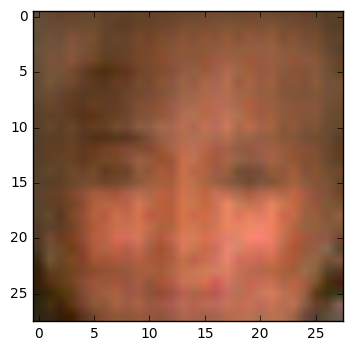

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.3794


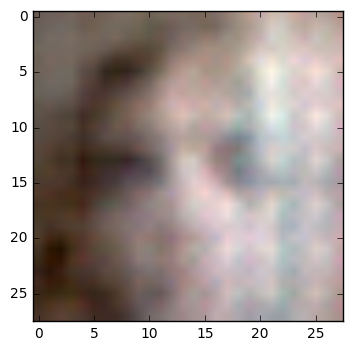

Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.3516


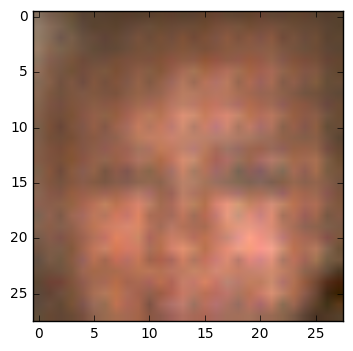

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.5247


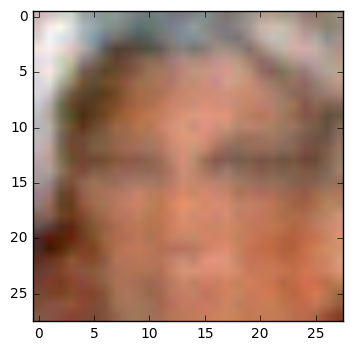

Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7997


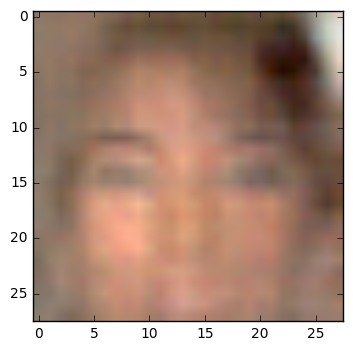

Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9218


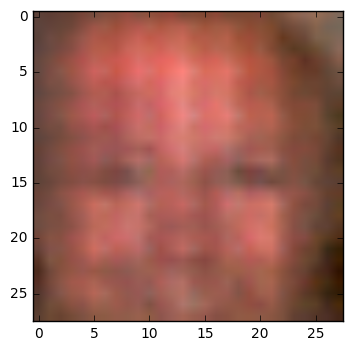

IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.